<h1><center> Práctica de Teoría de la Información</center></h1>


<h3><center>María Barroso Honrubia y Gloria del Valle Cano</center></h3>

En esta práctica se aplican técnicas de Teoría de la Información con el objetivo de estudiar la transmisión de información mutua entre dos neuronas principales, LP (Lateral Pyloric Neuron) y VD (Ventricular Dilator Neuron), las cuales pertenecen al sistema nervioso de un cangrejo. Gracias a la aportación de los datos facilitados de la sinapsis, se pueden distinguir las diferentes etapas en cada una de las neuronas:

* Control: etapa donde se mide el potencial de las neuronas en su estado inicial.
* Inyección de GABA: etapa donde se mide el potencial tras haber inyectado ácido $\gamma$-aminobutírico.
* Recuperación: etapa donde se mide el potencial de las neuronas tras dejar el sistema en reposo.

De esta manera estudiaremos la transmisión de información mutua tras un análisis completo de estas series, asumiendo que los *spikes* (aumentos rápidos del potencial) son los eventos que inicialmente tienen la información.

## 0. Importación de librerías

In [26]:
import math
import json
import zipfile
import pandas as pd
import numpy as np

from io import BytesIO
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from skimage.util import view_as_windows
from collections import defaultdict

file_path = '../../DatosSinapsisArtificial'
neurons = ['LP','VD']

## 1. Carga de datos
Utilizamos una función, $\texttt{zip\_to\_dataframe}$, para cargar los datos de la sinapsis, de manera que convertimos a un $\texttt{Dataframe}$ de $\texttt{pandas}$ para así manipularlos facilmente.

In [2]:
def zip_to_dataframe(file_path, file_name, neurons):
    """
    Load data from zip to pandas dataframe.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep='\t', index_col=False, names=neurons, skiprows=range(3), decimal=',')
        
def load_data(file_path, file_name, neurons):
    """
    Load data and show main information.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    print("________________ {0} ________________".format(file_name))
    trozo = zip_to_dataframe(file_path, file_name, neurons)
    print(trozo.head())
    print('Number of channels: {0}'.format(len(trozo.columns)))
    print('Number of samples per channel: {0}\n'.format(len(trozo)))
    return trozo

In [3]:
trozoC = load_data(file_path, 'TrozoC', neurons)
trozoG = load_data(file_path, 'TrozoG', neurons)
trozoR = load_data(file_path, 'TrozoR', neurons)

________________ TrozoC ________________
         LP        VD
0  0.004883  0.015259
1  0.001526  0.024109
2 -0.010681  0.031128
3 -0.022278  0.041809
4 -0.028076  0.045471
Number of channels: 2
Number of samples per channel: 19847700

________________ TrozoG ________________
         LP        VD
0 -0.006104  0.064697
1 -0.004272  0.075989
2 -0.003357  0.087280
3 -0.005188  0.092468
4 -0.007324  0.093384
Number of channels: 2
Number of samples per channel: 16384000

________________ TrozoR ________________
         LP        VD
0 -0.008240  0.084534
1 -0.009460  0.070190
2 -0.014038  0.049133
3 -0.021973  0.035400
4 -0.035095  0.022888
Number of channels: 2
Number of samples per channel: 16384000



## 2. Análisis de los datos

In [46]:
def chunk_analysis(trozo, name, n, dt):
    """
        Shows relevant information from file name selected.
        Args:
            trozo (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            n (int): numer of data points
            dt (float): interval
    """
    t = np.arange(0, n*dt, dt)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control ({0})'.format(name), fontsize=20)

    ax1.grid(True)
    ax1.plot(t, trozo.LP.iloc[:n], lw=0.4)
    ax1.set_title("LP", fontsize=16)
    
    ax2.grid(True)
    ax2.plot(t, trozo.VD.iloc[:n],'tab:orange', lw=0.4)
    ax2.set_title("VD", fontsize=16)

### 2.1. Análisis de cada uno de los trozos

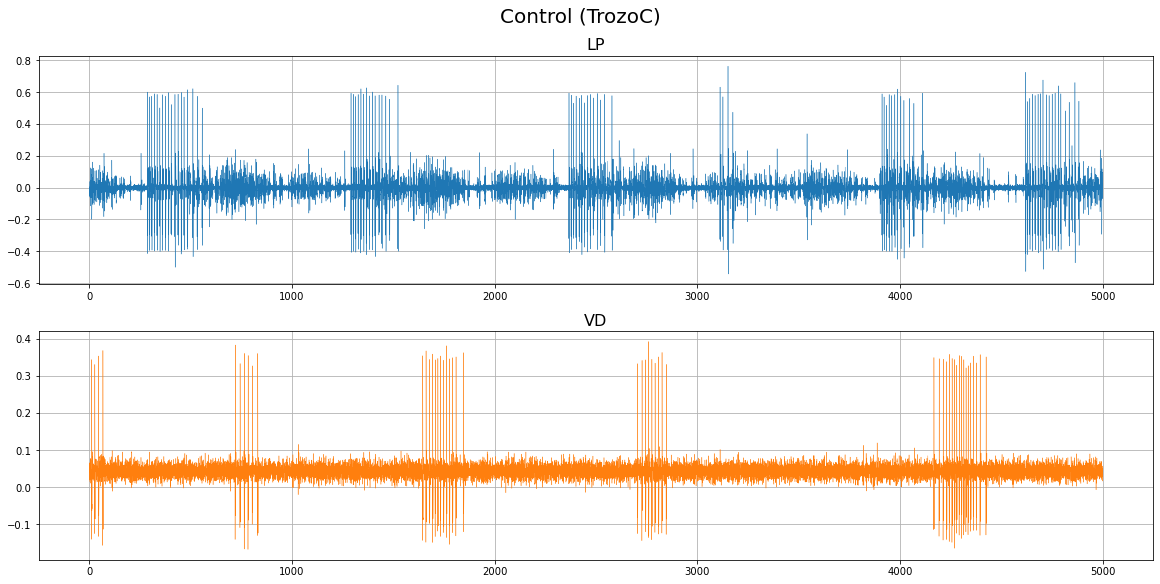

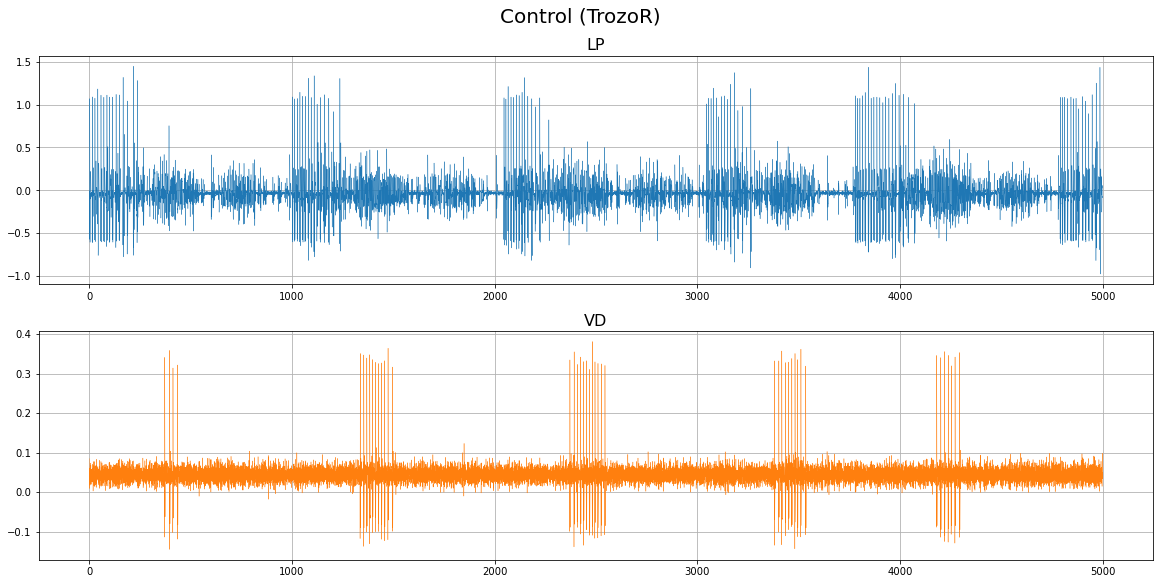

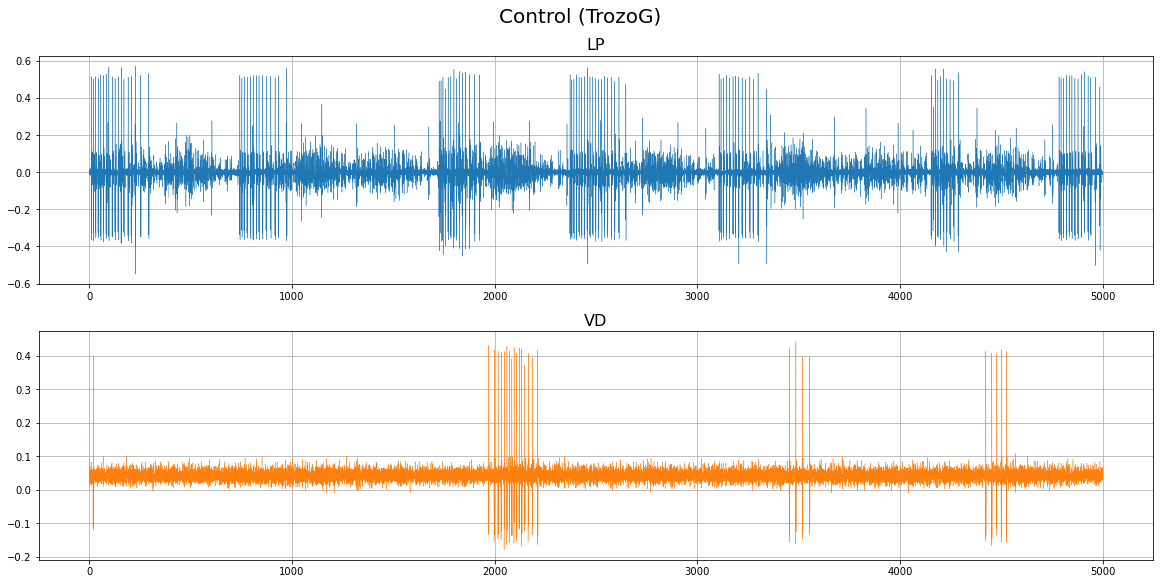

In [47]:
n = 50000
dt = 0.1
chunk_analysis(trozoC, "TrozoC", n, dt)
chunk_analysis(trozoR, "TrozoR", n, dt)
chunk_analysis(trozoG, "TrozoG", n, dt)

### 2.2. Detección de Spikes
#### 2.2.1. Utilizando el método estadístico
Evaluamos la dispersión y la distribución del dataset con el objetivo de encontrar los spikes y el umbral para cada neurona.

Dataset distribution: 
                 LP            VD
count  1.984770e+07  1.984770e+07
mean  -2.253853e-08  4.385849e-02
std    8.214042e-02  3.287948e-02
min   -7.101440e-01 -2.170715e+00
25%   -2.288800e-02  3.295900e-02
50%    3.050000e-04  4.364000e-02
75%    2.410900e-02  5.401600e-02
max    9.344480e-01  1.351624e+00


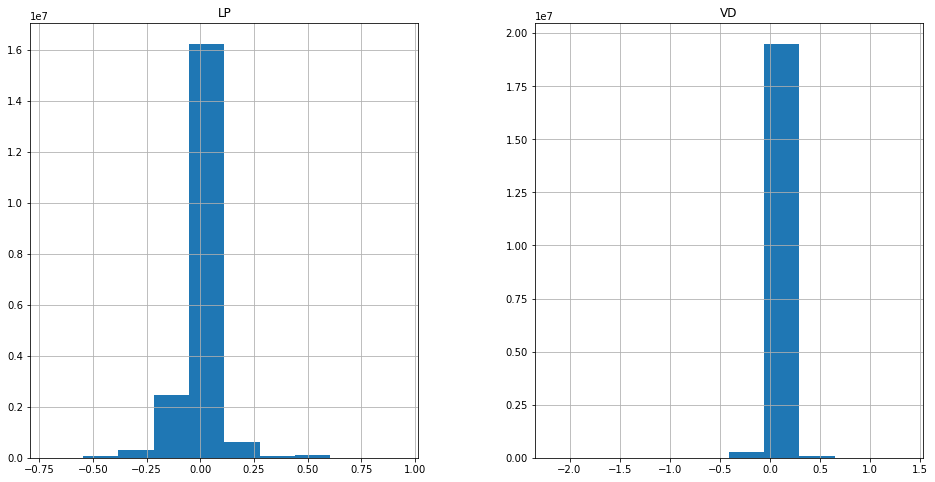

Threshold for each neuron:
LP    0.37
VD    0.20
dtype: float64


In [53]:
def get_threshold(df, precision=2):
    r = df.mean() + 4.5*df.std()
    return np.round(r + 0.5 * 10**(-precision), precision)

def get_spikes(trozo):
    """
    
    """
    print("Dataset distribution: ")
    print("{0}".format(trozo.describe()))
    histogram = trozo.hist(figsize = (16, 8))
    plt.suptitle()
    plt.show()
    threshold = get_threshold(trozo)
    print('Threshold for each neuron:')
    print('{0}'.format(threshold))
    return threshold

threshold = get_spikes(trozoC)

#### Utilizando la propia función de scipy

Total spikes (LP): 31231
Total spikes (VD): 22335


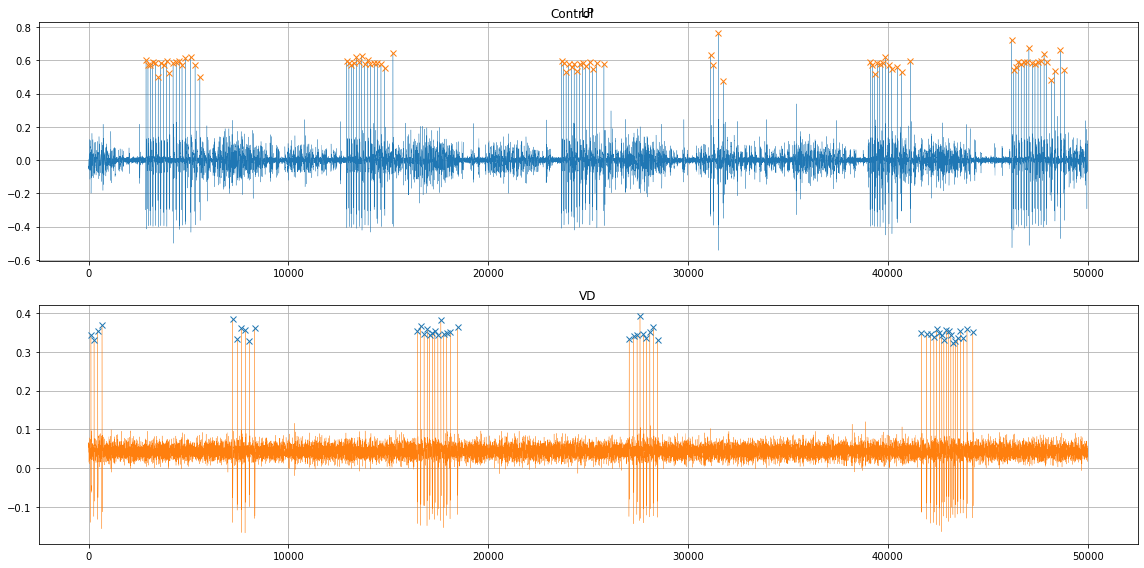

In [7]:
def find_events(trozo, n, threshold):
    
    clp_spikes, _ = find_peaks(trozo.LP[:n], threshold[0])
    cvd_spikes, _ = find_peaks(trozo.VD[:n], threshold[1])
    
    t_lp,_ = find_peaks(trozo.LP, threshold[0])
    t_vd,_ = find_peaks(trozo.VD, threshold[1])
    print("Total spikes (LP): {0}".format(len(t_lp)))
    print("Total spikes (VD): {0}".format(len(t_vd)))
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control')

    ax1.plot(trozo.LP[:n],lw=0.3)
    ax1.plot(clp_spikes, trozo.LP[:n][clp_spikes], "x")
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(trozo.VD[:n],'tab:orange',lw=0.3)
    ax2.plot(cvd_spikes, trozo.VD[:n][cvd_spikes], "x")
    ax2.set_title("VD")
    ax2.grid(True)

    fig.tight_layout()
    
    return t_lp, t_vd

clp_spikes, cvd_spikes = find_events(trozo, 50000, threshold)

### Distancia entre spikes

________ LP ________
Min: 3
Max: 22323
Mean: 635.3495036823567
Medium: 154.0
Q1: 24.80725
________ VD ________
Min: 4
Max: 29910
Mean: 888.3783469150175
Medium: 160.0
Q1: 17.1665


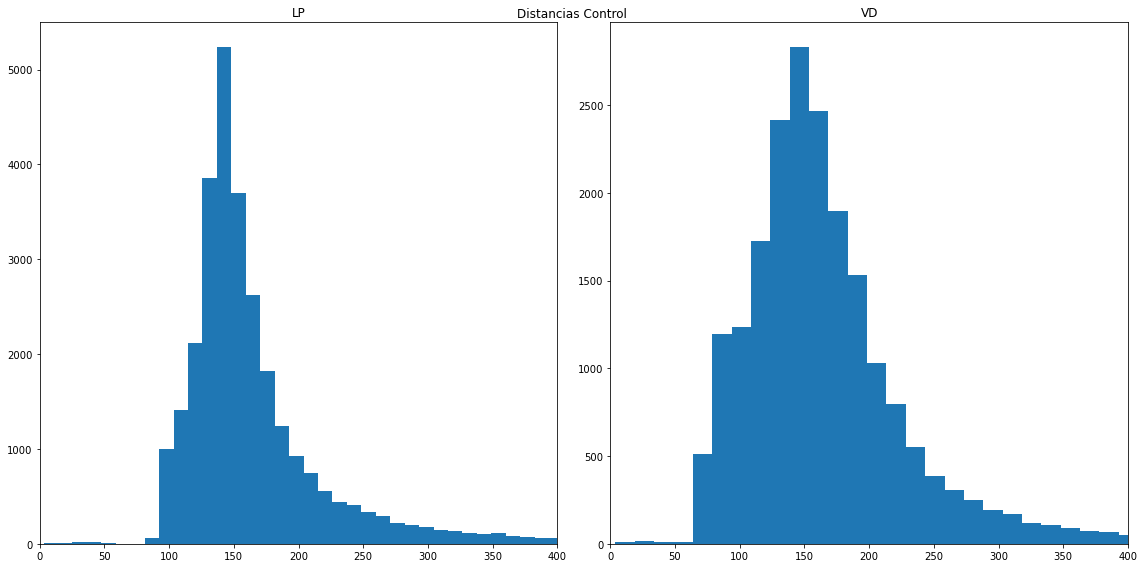

In [8]:
def distances_b_spikes(clp_spikes, cvd_spikes, q):
    clp_distances = np.diff(clp_spikes)
    cvd_distances = np.diff(cvd_spikes)
    
    print("________ LP ________")
    print('Min: {0}'.format(np.amin(clp_distances)))
    print('Max: {0}'.format(np.amax(clp_distances)))
    print('Mean: {0}'.format(np.mean(clp_distances)))
    print('Medium: {0}'.format(np.median(clp_distances)))
    print('Q1: {0}'.format(np.quantile(clp_distances, q)))
    print("________ VD ________")
    print('Min: {0}'.format(np.amin(cvd_distances)))
    print('Max: {0}'.format(np.amax(cvd_distances)))
    print('Mean: {0}'.format(np.mean(cvd_distances)))
    print('Medium: {0}'.format(np.median(cvd_distances)))
    print('Q1: {0}'.format(np.quantile(cvd_distances, q)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('Distancias Control')

    ax1.hist(clp_distances, bins=2000)
    ax1.set_xlim((0, 400))
    ax1.set_title("LP")

    ax2.hist(cvd_distances, bins=2000)
    ax2.set_title("VD")
    ax2.set_xlim((0, 400))

    fig.tight_layout()

distances_b_spikes(clp_spikes, cvd_spikes, 0.00025)

### Discretización

<ipython-input-9-6fbde12070bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozo.LP_events[clp_spikes] = 1
<ipython-input-9-6fbde12070bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozo.VD_events[cvd_spikes] = 1


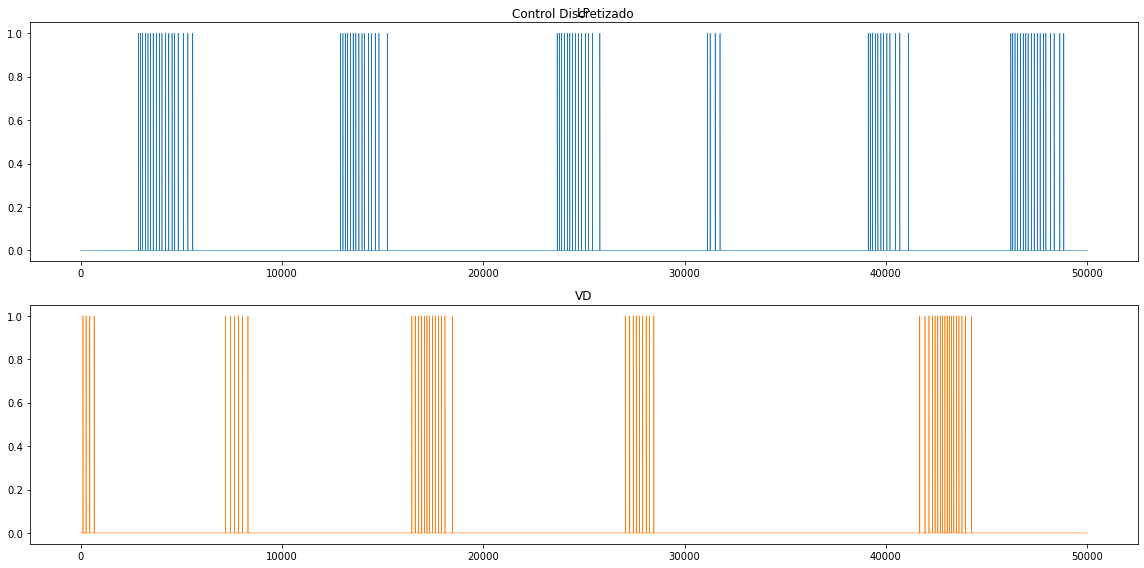

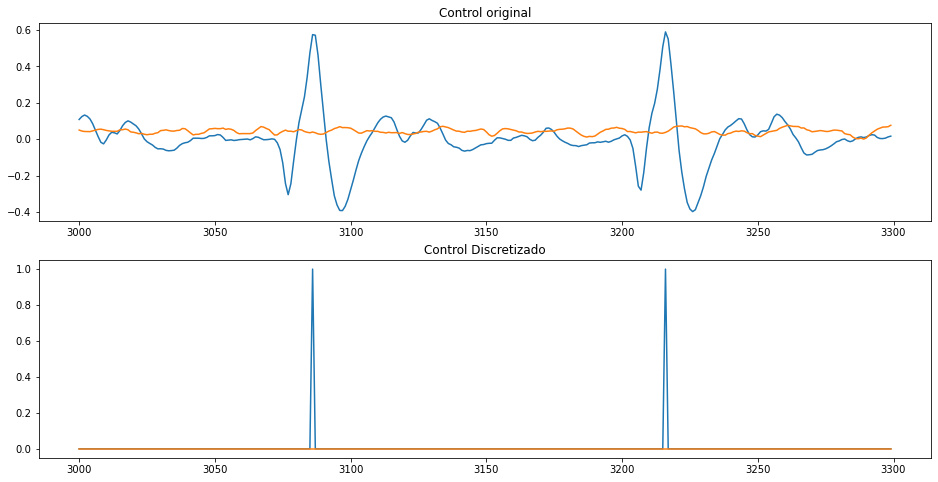

In [9]:
def discretize(trozo, n, sta, end):
    trozo['LP_events'] = 0
    trozo.LP_events[clp_spikes] = 1
    trozo['VD_events'] = 0
    trozo.VD_events[cvd_spikes] = 1
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle('Control Discretizado')
    ax1.plot(trozo.LP_events.iloc[:n],lw=0.6)
    ax1.set_title("LP")
    ax2.plot(trozo.VD_events.iloc[:n],'tab:orange',lw=0.6)
    ax2.set_title("VD")
    fig.tight_layout()
    
    fig, (ax3, ax4) = plt.subplots(2,1)
    fig.set_size_inches(16, 8)
    ax3.plot(trozo['LP'].iloc[sta:end])
    ax3.plot(trozo['VD'].iloc[sta:end])
    ax3.set_title("Control original")

    ax4.plot(trozo['LP_events'].iloc[sta:end])
    ax4.plot(trozo['VD_events'].iloc[sta:end],'tab:orange')
    ax4.set_title("Control Discretizado")
    
    return trozo


trozo = discretize(trozo, 50000, 3000, 3300)

### Tamaño de ventana

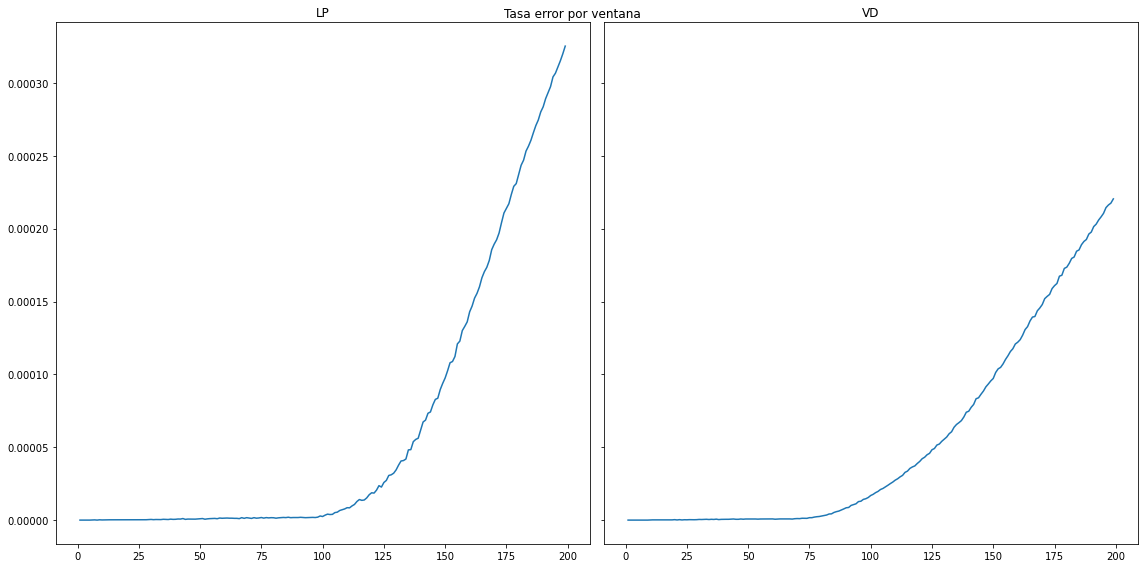

In [10]:
def get_errors_rate(series, bin_sizes):
    errors_rate = []
    for bin_size in bin_sizes:
        bins_spikes = view_as_windows(series,window_shape=bin_size, step=bin_size).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(series))
    return np.array(errors_rate)

def get_errors_rate_per_neuron(trozo, bin_sizes):
    clp_errors = get_errors_rate(np.array(trozo.LP_events),bin_sizes)
    cvd_errors = get_errors_rate(np.array(trozo.VD_events),bin_sizes)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(16, 8)
    fig.suptitle('Tasa error por ventana')
    ax1.plot(bin_sizes,clp_errors)
    ax1.set_title("LP")
    ax2.plot(bin_sizes,cvd_errors)
    ax2.set_title("VD")
    fig.tight_layout()
    
    return clp_errors, cvd_errors

clp_errors, cvd_errors = get_errors_rate_per_neuron(trozo, range(1,200))

### Analisis de ventanas

In [12]:
def to_words(series, nbits, nsteps):
    if nbits == 1:
        return np.array(list(map(str,series)))
    else:
        series_bin = view_as_windows(np.array(series),window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in series_bin])

def prob(x): # x : np of str (words)
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi, ex, ey

#### Ejemplo: tamaño de ventana = 1 & tamaño de palabras = 1

In [13]:
def show_probabilities(nbits, trozo):
    clp_words_1 = to_words(trozo.LP_events, nbits, nbits)
    cvd_words_1 = to_words(trozo.VD_events, nbits, nbits)
    prob_clp_1,prob_cvd_1 = prob(clp_words_1),prob(cvd_words_1)
    joint_prob_1 = joint_prob(clp_words_1,cvd_words_1)
    mi_1, e_clp_1, e_cvd_1 = MI(clp_words_1,cvd_words_1)
    print("Probabilidades Control LP con {0} bit: \n{1}".format(nbits, json.dumps(prob_clp_1,sort_keys=True, indent=2)))
    print("\nProbabilidades Control VD con {0} bit: \n{1}".format(nbits, json.dumps(prob_cvd_1,sort_keys=True, indent=2)))
    print("\nProbabilidades Conjuntas Control LP y VD con {0} bit: \n{1}".format(nbits, json.dumps(joint_prob_1,sort_keys=True, indent=2)))
    print("\nEntropía Control LP con {0} bit: {1}".format(nbits, e_clp_1))
    print("\nEntropía Control VD con {0} bit: {1}".format(nbits, e_cvd_1))
    print("\nInformación Mutua Control LP y VD con {0} bit: {1}".format(nbits, mi_1))

l_bits = [1,2,8]
[show_probabilities(i, trozo) for i in l_bits]

Probabilidades Control LP con 1 bit: 
{
  "0": 0.9984264675503962,
  "1": 0.0015735324496037324
}

Probabilidades Control VD con 1 bit: 
{
  "0": 0.9988746806934808,
  "1": 0.0011253193065191432
}

Probabilidades Conjuntas Control LP y VD con 1 bit: 
{
  "0|0": 0.9973011986275487,
  "0|1": 0.0011252689228474836,
  "1|0": 0.0015734820659320727,
  "1|1": 5.038367165968853e-08
}

Entropía Control LP con 1 bit: 0.01692072429498008

Entropía Control VD con 1 bit: 0.012645587614367295

Información Mutua Control LP y VD con 1 bit: 2.2264567559197284e-06
Probabilidades Control LP con 2 bit: 
{
  "00": 0.9968529351007925,
  "01": 0.0015712651843790464,
  "10": 0.0015757997148284184
}

Probabilidades Control VD con 2 bit: 
{
  "00": 0.9977493613869617,
  "01": 0.0011250673881608448,
  "10": 0.0011255712248774417
}

Probabilidades Conjuntas Control LP y VD con 2 bit: 
{
  "00|00": 0.9946024980224409,
  "00|01": 0.001124865853474206,
  "00|10": 0.0011255712248774417,
  "01|00": 0.00157116441703572

[None, None, None]

In [18]:
def show_multiple_probabilities(bin_sizes, trozo):
    lp_bins, vd_bins = {}, {}
    for bin_size in bin_sizes:
        lp_bins[bin_size] = view_as_windows(np.array(trozo.LP_events),window_shape=bin_size, step=bin_size).sum(axis=1)
        vd_bins[bin_size] = view_as_windows(np.array(trozo.VD_events),window_shape=bin_size, step=bin_size).sum(axis=1)
    
    return lp_bins, vd_bins

lp_bins, vd_bins = show_multiple_probabilities(range(1,201), trozo)

### Palabras 1 bit

In [19]:
bin_sizes = range(1,201)
nbits = 1
mi, elp, evd = [], [], []
for bin_size in bin_sizes:
    lp_words = to_words(lp_bins[bin_size], nbits, nbits)
    vd_words = to_words(vd_bins[bin_size], nbits, nbits)
    m_i, e_lp, e_vd = MI(lp_words,vd_words)
    mi.append(m_i)
    elp.append(e_lp)
    evd.append(e_vd)
mi = np.array(mi)
elp = np.array(elp)
evd = np.array(evd)
ti_lp_vd = mi/elp
ti_vd_lp = mi/evd

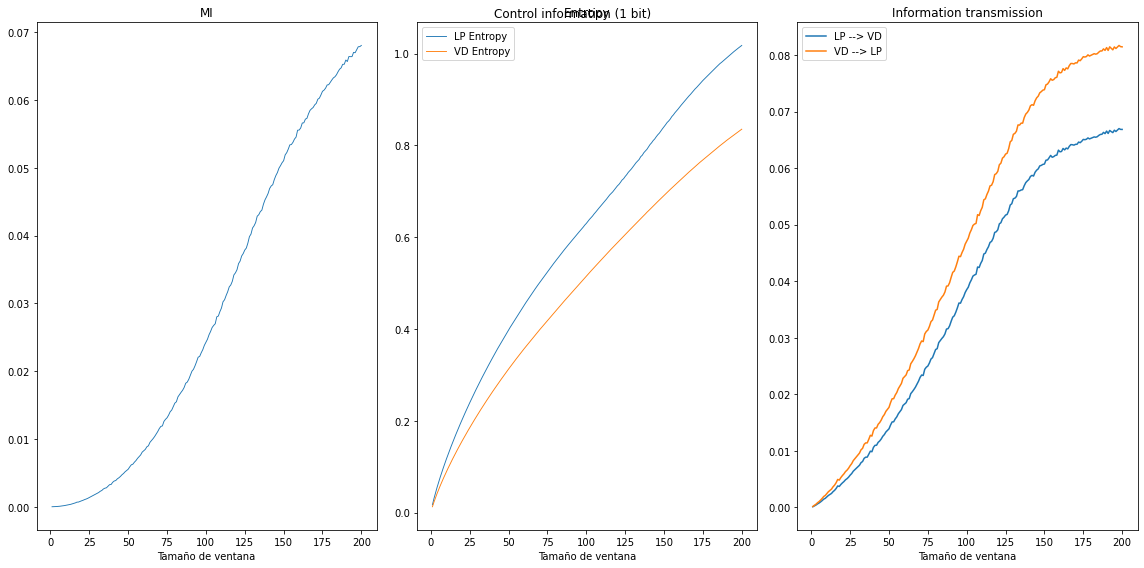

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 8)
fig.suptitle(f'Control information (1 bit)')

ax1.plot(bin_sizes,mi,lw=0.9)
ax1.set_title("MI")
ax1.set_xlabel("Tamaño de ventana")


ax2.plot(bin_sizes,elp,lw=0.9,label='LP Entropy')
ax2.plot(bin_sizes,evd,'tab:orange',label='VD Entropy',lw=0.9)
ax2.set_title("Entropy")
ax2.set_xlabel("Tamaño de ventana")
ax2.legend()

ax3.plot(bin_sizes,ti_lp_vd, label = 'LP --> VD')
ax3.plot(bin_sizes,ti_vd_lp,label = 'VD --> LP')
ax3.set_title('Information transmission')
ax3.set_xlabel("Tamaño de ventana")
ax3.legend()

fig.tight_layout()

### Para cada tamaño de palabra

In [21]:
bin_sizes = range(1,201)
nbits_size = range(1,9)
mi, elp, evd, ti_lp_vd, ti_vd_lp  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi[nbits] = np.array(mi_l)
    elp[nbits] = np.array(elp_l)
    evd[nbits] = np.array(evd_l)
    ti_lp_vd[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp[nbits] = np.array(mi_l)/np.array(evd_l)

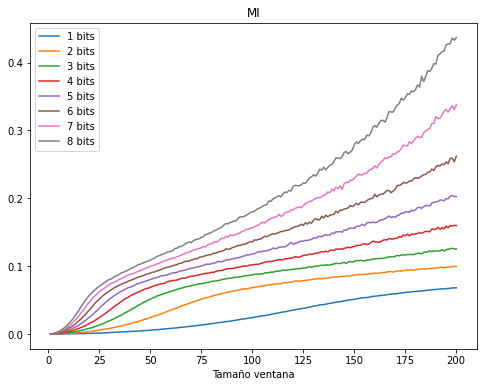

In [22]:
plt.figure(figsize=(8, 6))
plt.title("Mutual Information")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")
    row[0].xlabel("Bin size")

    row[1].plot(bin_sizes,elp[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].xlabel("Bin size")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd[nbits+1],label = 'LP --> VD')
    row[2].plot(bin_sizes,ti_vd_lp[nbits+1],label = 'VD --> LP')
    row[2].set_title(f'Information Transmission ({nbits+1} bits)')
    row[2].xlabel("Bin size")
    row[2].legend()
    
plt.show()

### Codificación palabras con desplazamiento solapantes

In [ ]:
bin_sizes = range(1,81)
nbits_size = range(1,9)
mi_s, elp_s, evd_s, ti_lp_vd_s, ti_vd_lp_s  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, 1)
        vd_words = to_words(vd_bins[bin_size], nbits, 1)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi_s[nbits] = np.array(mi_l)
    elp_s[nbits] = np.array(elp_l)
    evd_s[nbits] = np.array(evd_l)
    ti_lp_vd_s[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp_s[nbits] = np.array(mi_l)/np.array(evd_l)

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("MI")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi_s[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi_s[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} bits)")

    row[1].plot(bin_sizes,elp_s[nbits+1],label='LP')
    row[1].plot(bin_sizes,evd_s[nbits+1],label='VD')
    row[1].set_title(f"Entropy ({nbits+1} bits)")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd_s[nbits+1],label = 'LP --> VD')
    row[2].plot(bin_sizes,ti_vd_lp_s[nbits+1],label = 'VD --> LP')
    row[2].set_title(f'Information transmission ({nbits+1} bits)')
    row[2].legend()
    
plt.show()